# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [4]:
# libraries and packages import
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.utils import class_weight

In [5]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


In [6]:
# Colab optional setup
'''
IS_COLAB = "google.colab" in sys.modules
print("Running on Colab:", IS_COLAB)
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)
  #Adapt the folder to your specific one where you have downloaded the code
  %cd /content/drive/My Drive/path_to/exam-project
'''

'\nIS_COLAB = "google.colab" in sys.modules\nprint("Running on Colab:", IS_COLAB)\nif IS_COLAB:\n  from google.colab import drive\n  drive.mount(\'/content/drive/\', force_remount=True)\n  #Adapt the folder to your specific one where you have downloaded the code\n  %cd /content/drive/My Drive/path_to/exam-project\n'

# Data download and preprocess

Be careful if you are running this on COLAB or locally.
Due to some bugs, datasets creation is different.
Change the lower COLAB bool to True if running on COLAB.

In [7]:
COLAB = False  # if True, run on Google Colab, else on local repository


In [8]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
N_EPOCHS = 30
VERBOSE = True # True for debug prints


IF RUNNING ON COLAB

In [9]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
# Only working on Colab (and locally if tfds.load works correctly)

def load_from_tfds():
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )

    # labels are plant families
    class_names = ds_info.features['label'].names
    families = sorted({n.split('___')[0] for n in class_names})
    split_labels = families
    family_map = tf.constant([families.index(n.split('___')[0]) for n in class_names], dtype=tf.int32)

    # returns label as one-hot
    def to_ohe(img, lbl):
      idx = tf.gather(family_map, lbl)
      return img, tf.one_hot(idx, len(split_labels))

    ds_train = ds_train.map(to_ohe)
    ds_val   = ds_val.map(to_ohe)
    ds_test  = ds_test.map(to_ohe)

    print(split_labels)

    return ds_train, ds_val, ds_test, split_labels, ds_info


In [10]:
if COLAB:
    from preprocessing import preprocess

IF RUNNING ON LOCAL REPOSITORY

If you are working on a local repository, first of all you need to clone the dataset into a local folder. 
Execute the command "git clone https://github.com/spMohanty/PlantVillage-Dataset" in the terminal while you are in a known path. Make sure to set the base_path variable below to point to that cloned folder. 

Only run the git clone command if you haven’t already downloaded the dataset to your PC.

In [11]:
# if on colab, define preprocess.py (this is the same function defined in preprocessing.py)
if not COLAB:
    def preprocess(image, label, image_size=(128, 128)):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label


In [12]:
# Define local path to generate split
if not COLAB:
    from pathlib import Path

    base_path = Path(r"D:\progetto-daml") #Change according to the path where PlantVillage-Dataset is cloned.
    base_path = base_path / "PlantVillage-Dataset"

    OUTPUT_ROOT = base_path / "by_family" # 14 families splitting
    DS_DIR = OUTPUT_ROOT / "train"


In [13]:
#ONLY RUN FIRST TIME, AFTER DATASET CLONING
'''
SOURCE_DIR = base_path / "raw/color"
TRAIN_FRAC = 0.8 #change fractions
VAL_FRAC = 0.15
TEST_FRAC = 0.05

# Create output folders
for split in ("train","val","test"):
    folder = OUTPUT_ROOT / split
    if folder.exists():
        shutil.rmtree(folder) #remove pre-existing folder for new split
    folder.mkdir(parents=True, exist_ok=True)

# Collect folders name and map into family name folders
disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
families = sorted({d.name.split("___")[0] for d in disease_folders})

for split in ("train","val","test"):
    for fam in families:
        (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

# Splits files into train, validation and test for each family
for disease_dir in disease_folders:
    fam = disease_dir.name.split("___")[0]
    images = list(disease_dir.glob("*.*"))  # all image files
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n * VAL_FRAC)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # Put the datasets into the local folders
    for img in train_imgs:
        shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
    for img in val_imgs:
        shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
    for img in test_imgs:
        shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

print("Datasets paths are:\n",
    OUTPUT_ROOT / "train\n", 
    OUTPUT_ROOT / "val\n", 
    OUTPUT_ROOT / "test\n")
'''

'\nSOURCE_DIR = base_path / "raw/color"\nTRAIN_FRAC = 0.8 #change fractions\nVAL_FRAC = 0.15\nTEST_FRAC = 0.05\n\n# Create output folders\nfor split in ("train","val","test"):\n    folder = OUTPUT_ROOT / split\n    if folder.exists():\n        shutil.rmtree(folder) #remove pre-existing folder for new split\n    folder.mkdir(parents=True, exist_ok=True)\n\n# Collect folders name and map into family name folders\ndisease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])\nfamilies = sorted({d.name.split("___")[0] for d in disease_folders})\n\nfor split in ("train","val","test"):\n    for fam in families:\n        (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)\n\n# Splits files into train, validation and test for each family\nfor disease_dir in disease_folders:\n    fam = disease_dir.name.split("___")[0]\n    images = list(disease_dir.glob("*.*"))  # all image files\n    random.shuffle(images)\n\n    n = len(images)\n    n_train = int(n * TRAIN_FRAC)\n    n_v

In [14]:
# read split data into train, validation e test sets
def prepare_local_dataset():
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()]) #folders names

    ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='categorical',
    )

    ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    return ds_train_ohe, ds_val_ohe, ds_test_ohe, split_labels


# Training


In [15]:
#import MobileNetV2
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2(input_shape, num_classes, l2_coef=1e-3):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False   # freeze weights

    # Full model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False) 
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_coef)
    )(x)

    return Model(inputs,outputs)

In [ ]:
# preprocess and batch datasets. Useful objects are defined
def model_preprocess(COLAB):
    if COLAB:
        ds_train, ds_val, ds_test, split_labels, ds_info = load_from_tfds()
        ds_train = ds_train.shuffle(buffer_size=5000) # only shuffle train set
        ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
        ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        ds_train, ds_val, ds_test, split_labels = prepare_local_dataset()

    num_classes = len(split_labels)
    checkpoint = "best_model_14_families_transfer_exam.h5"

    return ds_train, ds_val, ds_test, split_labels, num_classes, checkpoint



In [17]:
# model compilation
def model_train(num_classes):
    model = build_mobilenetv2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(alpha = 0.25, gamma = 2),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
    model.summary()
    return model


In [18]:
# program running (all the functions above are executed)
train_set, val_set, test_set, split_labels, num_classes, checkpoint_file = model_preprocess(COLAB)


Found 43429 files belonging to 14 classes.
Found 8129 files belonging to 14 classes.
Found 2747 files belonging to 14 classes.


In [19]:
# debug prints: labels, number of labels, checkpoint file name
if VERBOSE:
    print(split_labels)
    print(len(split_labels))
    print(checkpoint_file)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
14
best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


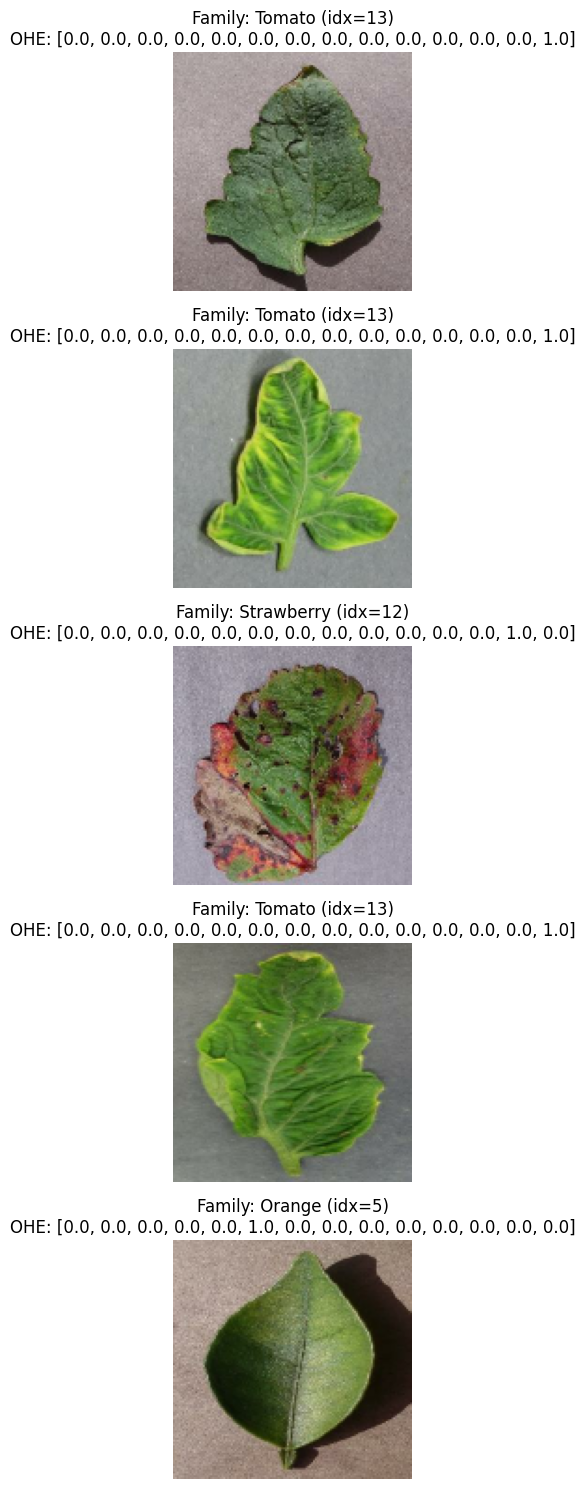

In [20]:
# debug print for families - ohe labels cross check
def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Tensors are converted into numpy arrays
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # one-hot vector
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # family index
        fam_name = split_labels[fam_idx]

        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# example on train batch
if VERBOSE:
    display_samples_with_labels_ohe(train_set, num_samples=5)


In [21]:
# counting number of images per class
from collections import Counter

if VERBOSE:
    counts = Counter()
    
    for _, batch_labels in train_set:
        idxs = np.argmax(batch_labels.numpy(), axis=1)
        counts.update(idxs)
    
    print(f"Number of classes: {len(split_labels)}")
    print("Number of images per class:")
    for idx in range(len(split_labels)):
        print(f"{split_labels[idx]}: {counts[idx]} images")


KeyboardInterrupt: 

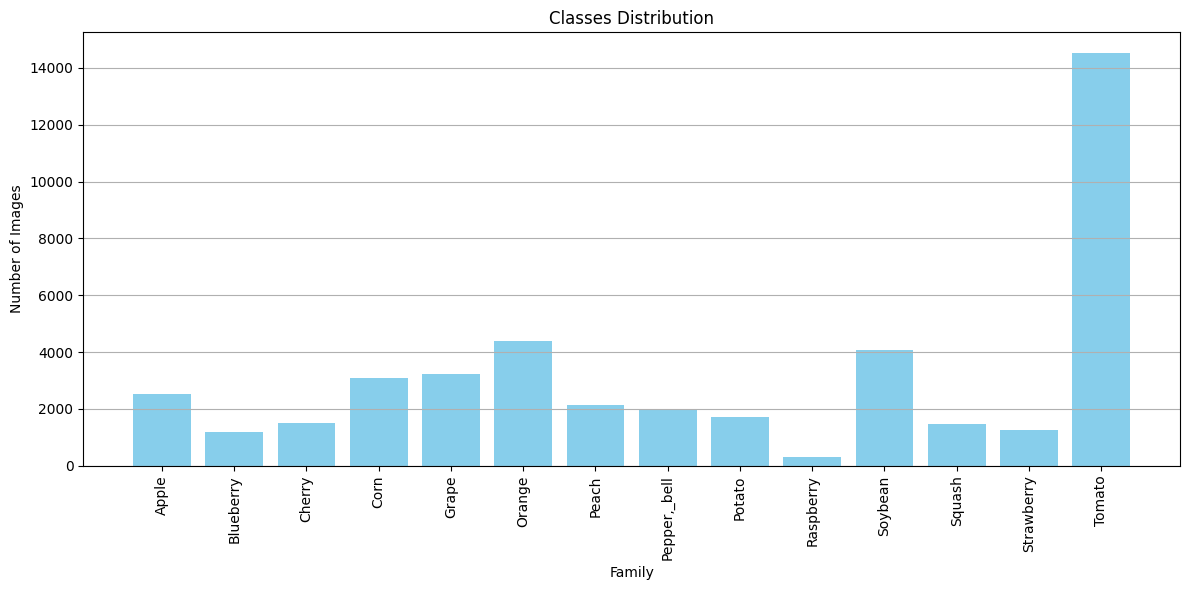

In [ ]:
# Visualize the class numbers distribution
if VERBOSE:
    counts_list = [counts[i] for i in range(len(split_labels))]

    plt.figure(figsize=(12, 6))
    plt.bar(split_labels, counts_list, color='skyblue')
    plt.xlabel('Family')
    plt.ylabel('Number of Images')
    plt.title('Classes Distribution')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
# Print element format
if VERBOSE:
    print("Element spec:", train_set.element_spec)
    
    # Example on a batch
    for batch in train_set.take(1):
        x, y = batch
        print("x shape:", x.shape, "  dtype:", x.dtype)
        print("y shape:", y.shape, "  dtype:", y.dtype)


In [ ]:
model = model_train(num_classes, l2_coef=1e-3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │       286,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,544,718 (9.71 MB)

 Trainable params: 286,734 (1.09 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#label conversion from ohe to index 
all_labels = []
for batch in train_set:
    images, labels_ohe = batch
    for lab in labels_ohe:
        all_labels.append(int(np.argmax(lab)))

all_labels = np.array(all_labels)
classes=np.unique(all_labels)

# weights calculation (total examples number / (classes number * example in ith class) )
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

class_w = dict(zip(classes, weights))

# print family name and corresponding weight
if VERBOSE:
    for idx, w in class_w.items():
        name = split_labels[idx]
        print(f"{name:15s}: {w:.4f}")

Apple          : 1.2232
Blueberry      : 2.5829
Cherry         : 2.0355
Corn           : 1.0072
Grape          : 0.9551
Orange         : 0.7042
Peach          : 1.4598
Pepper,_bell   : 1.5675
Potato         : 1.8025
Raspberry      : 10.4800
Soybean        : 0.7618
Squash         : 2.1131
Strawberry     : 2.4797
Tomato         : 0.2136


In [ ]:
# Model head training

history_head = model.fit(
    train_set,
    validation_data=val_set,
    epochs=5,
    class_weight=class_w, #optional: training with weighted classes
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 877s 641ms/step - accuracy: 0.5293 - loss: 0.8093 - val_accuracy: 0.7011 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 933s 687ms/step - accuracy: 0.6573 - loss: 0.6480 - val_accuracy: 0.7259 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 899s 662ms/step - accuracy: 0.6845 - loss: 0.6383 - val_accuracy: 0.7476 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 898s 661ms/step - accuracy: 0.6963 - loss: 0.6656 - val_accuracy: 0.7419 - val_loss: 0.6010 - learning_rate: 0.0010
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 907s 650ms/step - accuracy: 0.7349 - loss: 0.5533 - val_accuracy: 0.7952 - val_loss: 0.4205 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [ ]:
#train head + 50 layers
base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-50]: # unfreeze 50 layers
    layer.trainable = False

optimizer = Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=CategoricalFocalCrossentropy(alpha = 0.25, gamma = 2),
    metrics=['accuracy']
)

In [ ]:
history_ft = model.fit(
    train_set, 
    validation_data=val_set,
    epochs=20,
    class_weight=class_w, #optional: training with weighted classes
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True, verbose=1),
    ]
)

Epoch 1/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.4572 - loss: 1.7037
Epoch 1: val_loss improved from inf to 0.82381, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1365s 958ms/step - accuracy: 0.4572 - loss: 1.7034 - val_accuracy: 0.6675 - val_loss: 0.8238
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.6055 - loss: 0.7657
Epoch 2: val_loss improved from 0.82381 to 0.58857, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1349s 993ms/step - accuracy: 0.6055 - loss: 0.7656 - val_accuracy: 0.7296 - val_loss: 0.5886
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.6712 - loss: 0.5729
Epoch 3: val_loss improved from 0.58857 to 0.48407, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1402s 993ms/step - accuracy: 0.6713 - loss: 0.5729 - val_accuracy: 0.7567 - val_loss: 0.4841
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.7154 - loss: 0.4636
Epoch 4: val_loss improved from 0.48407 to 0.43179, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1376s 1s/step - accuracy: 0.7154 - loss: 0.4636 - val_accuracy: 0.7751 - val_loss: 0.4318
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.7458 - loss: 0.3964
Epoch 5: val_loss improved from 0.43179 to 0.37479, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1338s 985ms/step - accuracy: 0.7458 - loss: 0.3964 - val_accuracy: 0.8007 - val_loss: 0.3748
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.7734 - loss: 0.3410
Epoch 6: val_loss improved from 0.37479 to 0.34996, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1410s 1s/step - accuracy: 0.7734 - loss: 0.3410 - val_accuracy: 0.8065 - val_loss: 0.3500
Epoch 7/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.7983 - loss: 0.2999
Epoch 7: val_loss improved from 0.34996 to 0.33481, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1341s 987ms/step - accuracy: 0.7983 - loss: 0.2999 - val_accuracy: 0.8133 - val_loss: 0.3348
Epoch 8/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.8141 - loss: 0.2769
Epoch 8: val_loss improved from 0.33481 to 0.29982, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1361s 999ms/step - accuracy: 0.8141 - loss: 0.2769 - val_accuracy: 0.8332 - val_loss: 0.2998
Epoch 9/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.8359 - loss: 0.2497
Epoch 9: val_loss improved from 0.29982 to 0.29457, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1418s 1s/step - accuracy: 0.8359 - loss: 0.2497 - val_accuracy: 0.8357 - val_loss: 0.2946
Epoch 10/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8490 - loss: 0.2289
Epoch 10: val_loss improved from 0.29457 to 0.27760, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1331s 978ms/step - accuracy: 0.8490 - loss: 0.2289 - val_accuracy: 0.8477 - val_loss: 0.2776
Epoch 11/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8614 - loss: 0.2189
Epoch 11: val_loss improved from 0.27760 to 0.25778, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1413s 1s/step - accuracy: 0.8614 - loss: 0.2189 - val_accuracy: 0.8668 - val_loss: 0.2578
Epoch 12/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.8767 - loss: 0.2007
Epoch 12: val_loss improved from 0.25778 to 0.25086, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1378s 1s/step - accuracy: 0.8767 - loss: 0.2007 - val_accuracy: 0.8612 - val_loss: 0.2509
Epoch 13/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.8806 - loss: 0.1922
Epoch 13: val_loss improved from 0.25086 to 0.23925, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1368s 989ms/step - accuracy: 0.8806 - loss: 0.1922 - val_accuracy: 0.8706 - val_loss: 0.2392
Epoch 14/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8956 - loss: 0.1778
Epoch 14: val_loss improved from 0.23925 to 0.23273, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1462s 1s/step - accuracy: 0.8956 - loss: 0.1777 - val_accuracy: 0.8748 - val_loss: 0.2327
Epoch 15/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9011 - loss: 0.1725
Epoch 15: val_loss improved from 0.23273 to 0.21383, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1569s 1s/step - accuracy: 0.9011 - loss: 0.1725 - val_accuracy: 0.8882 - val_loss: 0.2138
Epoch 16/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.9128 - loss: 0.1591
Epoch 16: val_loss improved from 0.21383 to 0.20384, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1473s 1s/step - accuracy: 0.9128 - loss: 0.1591 - val_accuracy: 0.8979 - val_loss: 0.2038
Epoch 17/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.9176 - loss: 0.1530
Epoch 17: val_loss did not improve from 0.20384
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1429s 1s/step - accuracy: 0.9176 - loss: 0.1530 - val_accuracy: 0.8751 - val_loss: 0.2108
Epoch 18/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9227 - loss: 0.1464
Epoch 18: val_loss improved from 0.20384 to 0.19274, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1469s 1s/step - accuracy: 0.9227 - loss: 0.1464 - val_accuracy: 0.8931 - val_loss: 0.1927
Epoch 19/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9288 - loss: 0.1399
Epoch 19: val_loss improved from 0.19274 to 0.18395, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 929s 644ms/step - accuracy: 0.9288 - loss: 0.1399 - val_accuracy: 0.8967 - val_loss: 0.1840
Epoch 20/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9355 - loss: 0.1323
Epoch 20: val_loss improved from 0.18395 to 0.18059, saving model to best_model_14_families_categorical_newsplit_mobilenet_50layers_classweight_.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 565s 414ms/step - accuracy: 0.9355 - loss: 0.1323 - val_accuracy: 0.9017 - val_loss: 0.1806
Restoring model weights from the end of the best epoch: 20.


# CNN training history


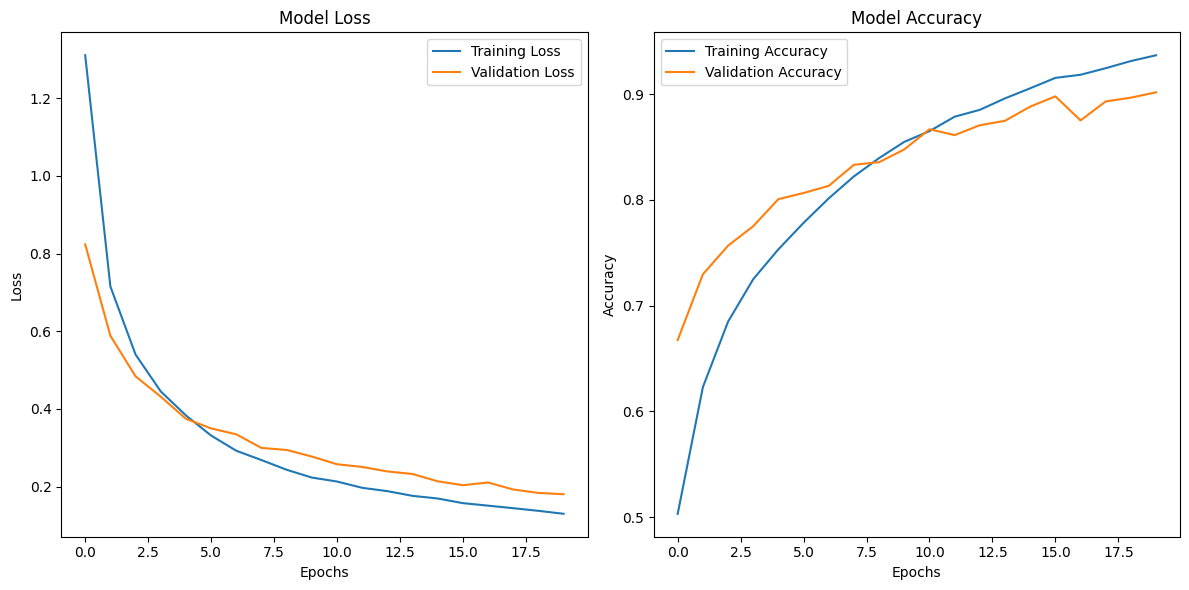

In [ ]:
# plot training history (Loss and Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['loss'], label='Training Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_ft.history['accuracy'], label='Training Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

The following code is left here as a backup in case of problem with the compilation wit model_evaluation.ipynb

In [ ]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential

#model = keras.models.load_model('best_model_14_families.h5', compile=False) #insert file name

y_true = [] # ground truth
y_pred = [] # prediction
y_score = [] # predictions vector
for images, labels in test_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282

In [ ]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.886422
Precision: 0.890348
Recall: 0.886422
F1-score: 0.887357


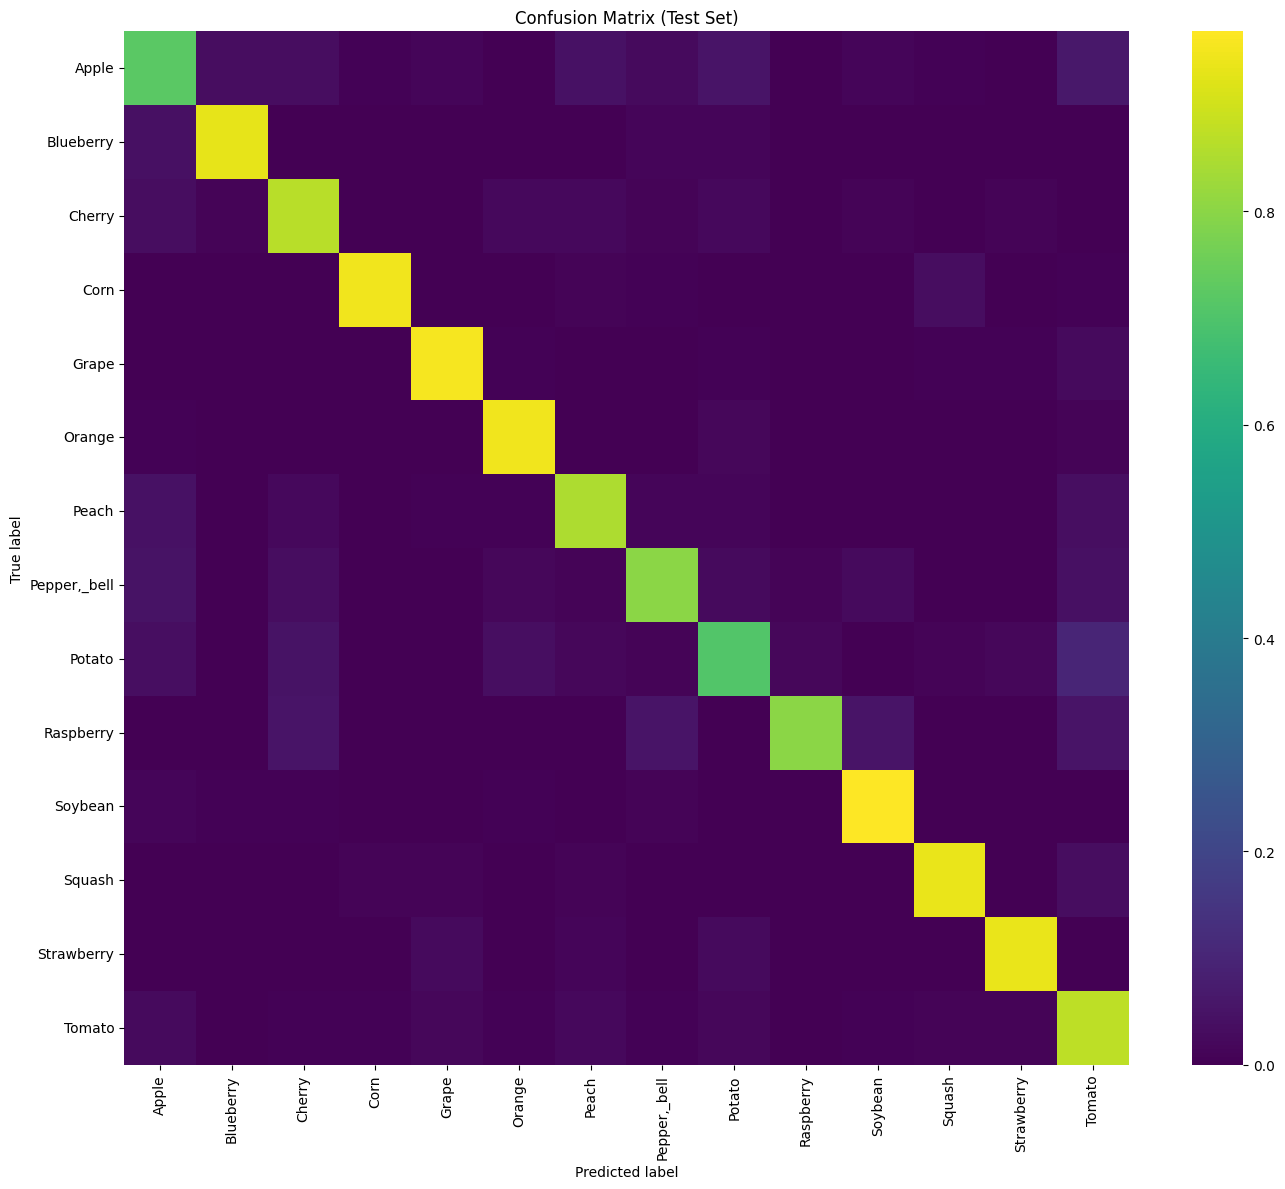

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis', xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


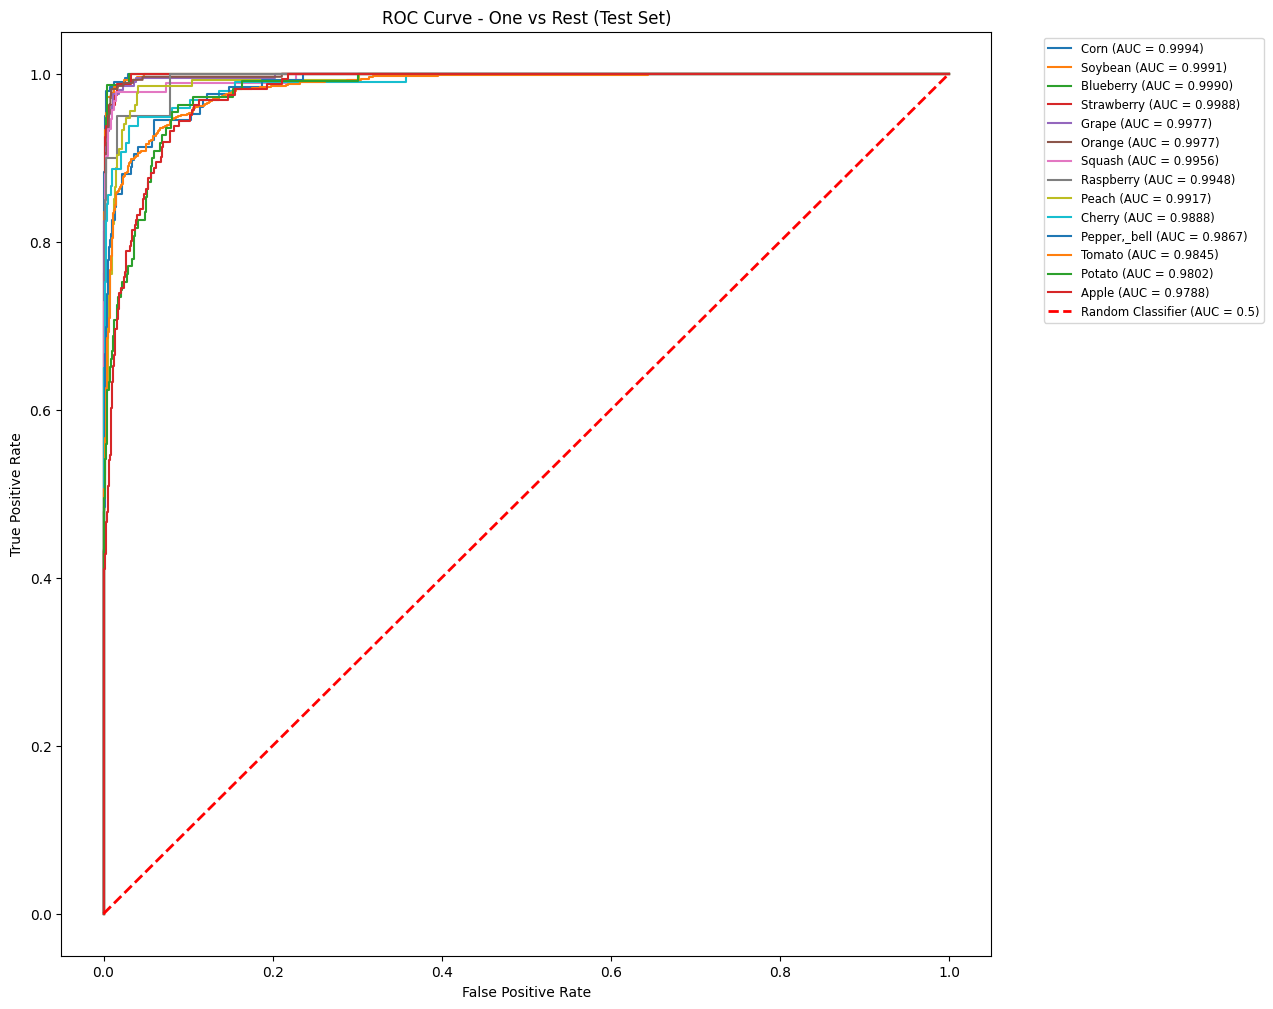

In [ ]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')

plt.show()


In [ ]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


              precision    recall  f1-score   support

       Apple       0.70      0.72      0.71       161
   Blueberry       0.88      0.93      0.90        76
      Cherry       0.78      0.87      0.82        97
        Corn       0.97      0.95      0.96       197
       Grape       0.90      0.96      0.93       206
      Orange       0.94      0.95      0.95       276
       Peach       0.75      0.85      0.80       134
Pepper,_bell       0.83      0.80      0.82       126
      Potato       0.66      0.71      0.68       109
   Raspberry       0.80      0.80      0.80        20
     Soybean       0.96      0.97      0.96       255
      Squash       0.83      0.93      0.88        92
  Strawberry       0.86      0.94      0.90        80
      Tomato       0.95      0.87      0.91       918

    accuracy                           0.89      2747
   macro avg       0.84      0.87      0.86      2747
weighted avg       0.89      0.89      0.89      2747

